# The (Very) Short Introduction to EasyTS

**Author:** Hannu Parviainen <br>
**Edited:** 9 August 2024

This notebook is a less verbose version of the (not so) short introduction into transmission spectroscopy with EasyTS, showing how a typical transmission spectroscopy analysis would look like without all the comments and more useful to be used as a template for a new analysis.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from matplotlib.pyplot import subplots, setp
from numpy import geomspace, linspace, newaxis, diff, zeros

from easyts import EasyTS, TSData

## Data preparation

In [4]:
def read_data(fname, name=""):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values, name=name)

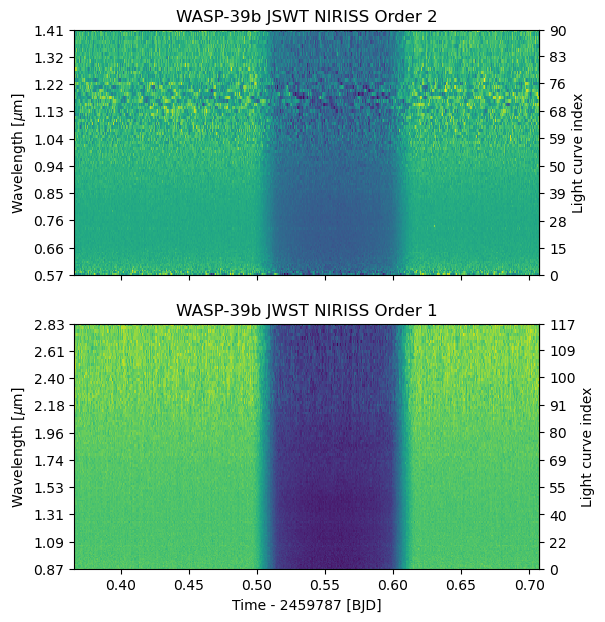

In [5]:
d1 = read_data('data/nirHiss_order_1.h5', "WASP-39b JWST NIRISS Order 1")
d1.remove_outliers()

d2 = read_data('data/nirHiss_order_2.h5', "WASP-39b JSWT NIRISS Order 2")
d2.remove_outliers()

db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
db.errors[:,:] = diff(db.fluxes[:, :140]).std(1)[:,newaxis]

fig = db.plot(figsize=(6, 7))

In [6]:
ts = EasyTS('01a_lowres_power2', ldmodel='power-2', data=db, nk=50, nldc=10, nthreads=1)
ts.set_prior('tc', 'NP', 2459694.286, 0.003)
ts.set_prior('p', 'NP', 4.05487, 1e-5)
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

In [7]:
ts.ps

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 2459694.286, σ = 0.003)            [    -inf ..      inf],
   2 |G| p              N(μ = 4.05487, σ = 1e-05)                [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00.57277  N(μ = 0.755, σ = 0.018)                  [    -inf ..      inf],
   7 |G| ldc2_00.57277  N(μ = 0.835, σ = 0.033)                  [    -inf ..      inf],
   8 |G| ldc1_00.82264  N(μ = 0.61, σ = 0.016)                   [    -inf ..      inf],
   9 |G| ldc2_00.82264  N(μ = 0.711, σ = 0.027)                  [    -inf ..      inf],
  10 |G| ldc1_01.07250  N(μ = 0.546, σ = 0.014)                  [    -inf ..      inf],
  11 |G| ldc2_01.0725

### Customize the radius ratio knot locations

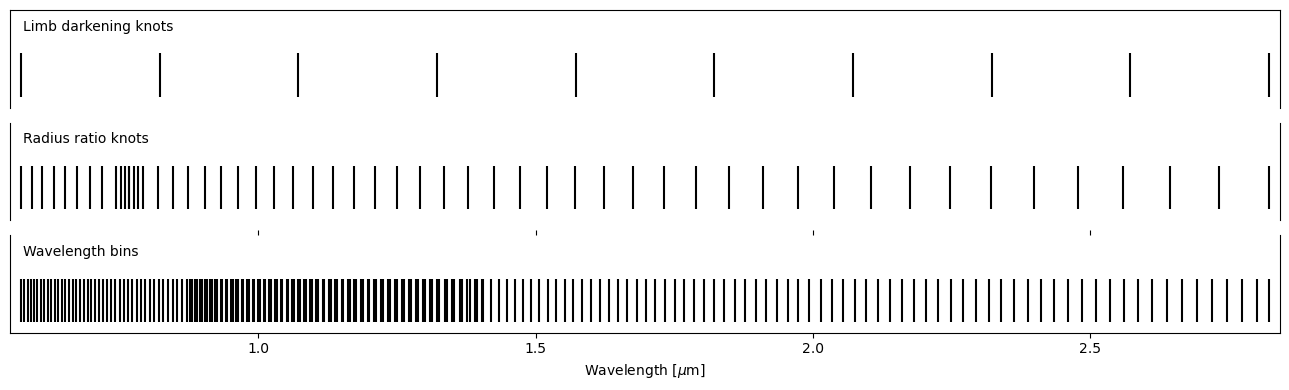

In [8]:
ts.set_radius_ratio_knots(geomspace(*ts.wavelength[[0, -1]], 50))
ts.add_radius_ratio_knots(linspace(0.768-0.015, 0.768+0.015, 5))
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.plot_setup();

### Fit the white light curve

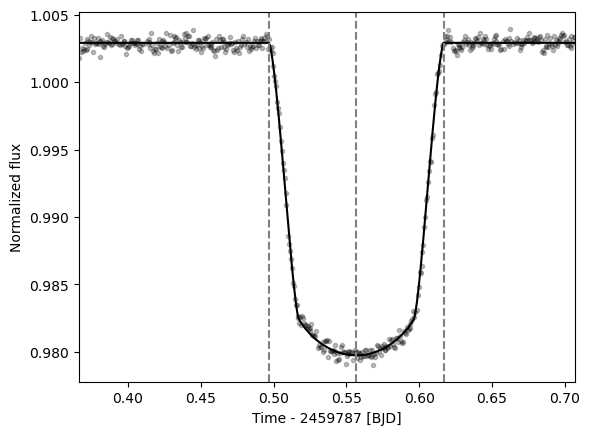

In [9]:
ts.fit_white()
fig = ts.plot_white()

## Normalise the baseline

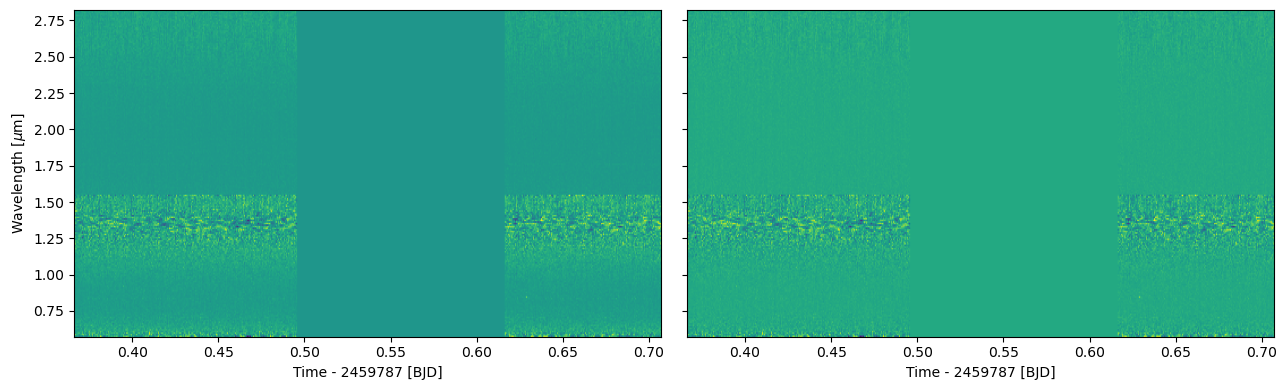

In [10]:
ts.normalize_baseline(1)
fig = ts.plot_baseline()

### Set up multiprocessing

In [11]:
def lnpostf(pv):
    return ts.lnposterior(pv)

In [12]:
pool = Pool(8)

### Fit the transmission spectrum

Global optimisation:   0%|          | 0/1500 [00:00<?, ?it/s]

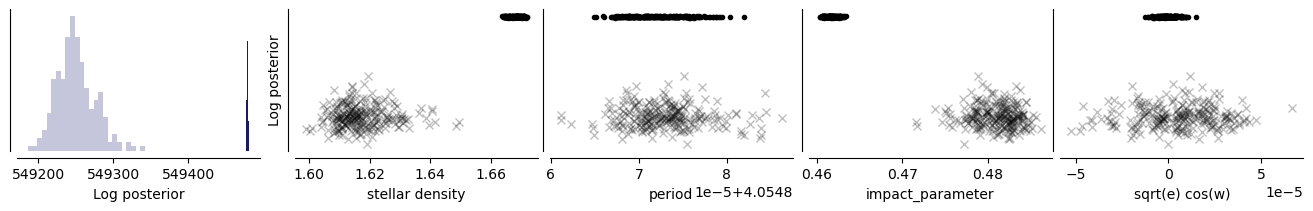

In [16]:
ts.fit(niter=1500, npop=250, pool=pool, lnpost=lnpostf)

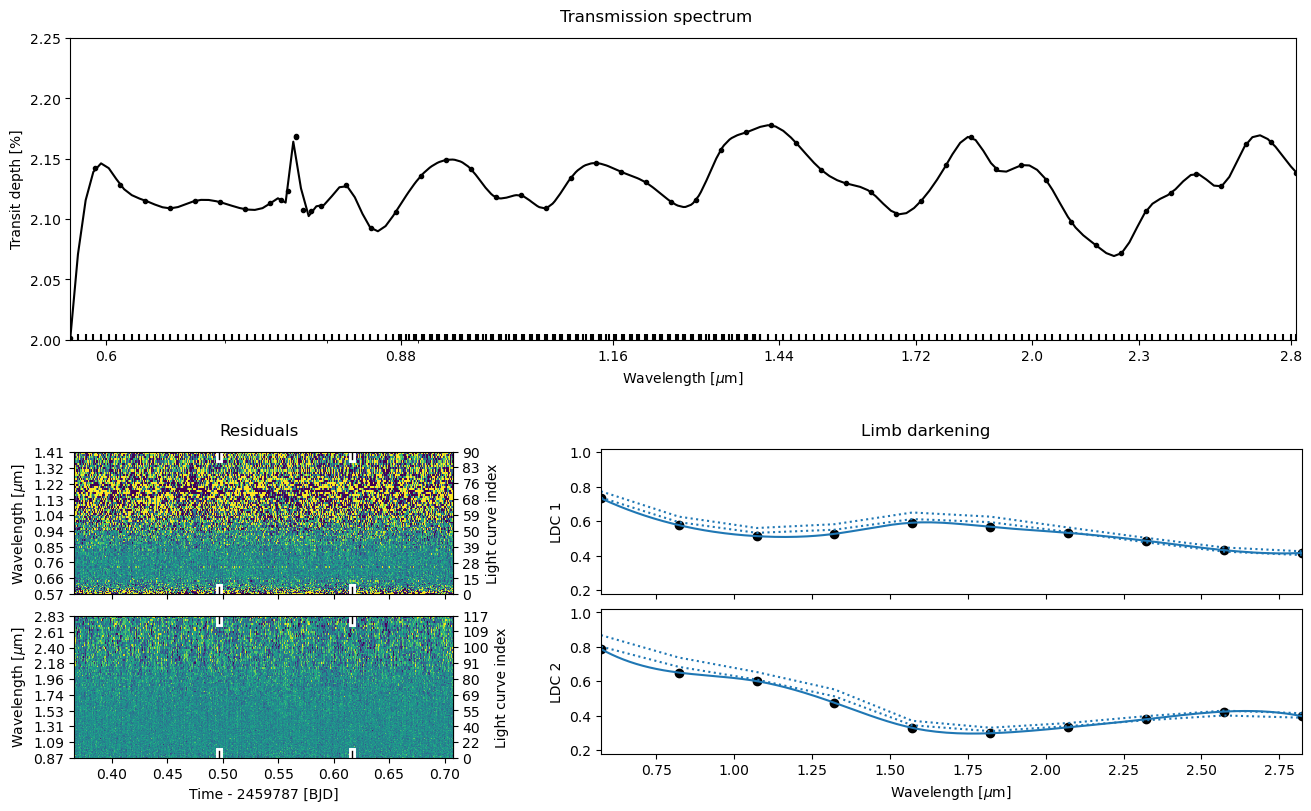

In [17]:
fig = ts.plot_fit(result='fit', figsize=(13,8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### MCMC sampling

In [18]:
ts.sample(100, thin=10, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
import astropy.io.fits as pf

import codecs
import json
import pickle

from easyts.ldtkld import LDTkLD
from astropy.table import Table

def save(self, overwrite: bool = False) -> None:
    """Saves the EasyTS analysis to a FITS file.

    Parameters
    ----------
    overwrite : bool, optional
        Flag indicating whether to overwrite an existing file with the same name.
    """
    pri = pf.PrimaryHDU()
    pri.header['name'] = self.name
    pri.header['t0'] = self.transit_center
    pri.header['t14'] = self.transit_duration
    pri.header['ndgroups'] = self.data.ngroups

    pr = pf.ImageHDU(name='priors')
    priors = [pickle.dumps(p) for p in self.ps]
    pr.header['priors'] = json.dumps(codecs.encode(pickle.dumps(priors), "base64").decode())

    if isinstance(self._tsa.ldmodel, LDTkLD):
        ldm = self._tsa.ldmodel
        pri.header['ldmodel'] = 'ldtk'
        pri.header['ldtkld'] = json.dumps(codecs.encode(pickle.dumps((ldm.sc.filters, ldm.sc.teff, ldm.sc.logg,
                                                                      ldm.sc.metal, ldm.dataset)), "base64").decode())
    else:
        pri.header['ldmodel'] = self._tsa.ldmodel

    k_knots = pf.ImageHDU(self._tsa.k_knots, name='k_knots')
    ld_knots = pf.ImageHDU(self._tsa.ld_knots, name='ld_knots')
    hdul = pf.HDUList([pri, k_knots, ld_knots, pr])

    for i, d in enumerate(self.data.data): 
        flux = pf.ImageHDU(d.fluxes, name=f'flux_{i}')
        flux.header['name'] = d.name
        ferr = pf.ImageHDU(d.errors, name=f'ferr_{i}')
        wave = pf.ImageHDU(d.wavelength, name=f'wavelength_{i}')
        time = pf.ImageHDU(d.time, name=f'time_{i}')
        hdul.extend([time, wave, flux, ferr])
        
    if self._tsa.de is not None:
        de = pf.BinTableHDU(Table(self._tsa._de_population, names=self.ps.names), name='DE')
        de.header['npop'] = self._tsa.de.n_pop
        de.header['ndim'] = self._tsa.de.n_par
        de.header['imin'] = self._tsa.de.minimum_index
        hdul.append(de)

    if self._tsa.sampler is not None:
        mc = pf.BinTableHDU(Table(self._tsa.sampler.flatchain, names=self.ps.names), name='MCMC')
        mc.header['npop'] = self._tsa.sampler.nwalkers
        mc.header['ndim'] = self._tsa.sampler.ndim
        hdul.append(mc)

    hdul.writeto(f"{self.name}.fits", overwrite=True)

save(ts)

In [55]:
from easyts.tsdata import TSDataSet
from pytransit.param import ParameterSet

def load_model(fname, name: str | None = None):
    """Loads an EasyTS analysis from a FITS file.

    Parameters
    ----------
    fname : str
        The name of the savefile.

    name : str, optional
        The name of the new EasyTS model. If not provided, the original analysis name will be used.

    Returns
    -------
    a : EasyTS
        An EasyTS analysis.

    Raises
    ------
    IOError
        If there is an error while opening or reading the file.

    ValueError
        If the file format is invalid or does not match the expected format.
    """
    with pf.open(fname) as hdul:
        d = []
        for i in range(hdul[0].header['NDGROUPS']):
            print(hdul[f'FLUX_{i}'].header)
            d.append(TSData(hdul[f'TIME_{i}'].data.astype('d'), hdul[f'WAVELENGTH_{i}'].data.astype('d'),
                            hdul[f'FLUX_{i}'].data.astype('d'), hdul[f'FERR_{i}'].data.astype('d'), 
                            name=hdul[f'FLUX_{i}'].header['NAME']))
        data = TSDataSet(d)
        
        if hdul[0].header['LDMODEL'] == 'ldtk':
            filters, teff, logg, metal, dataset = pickle.loads(codecs.decode(json.loads(hdul[0].header['LDTKLD']).encode(), "base64"))
            ldm = LDTkLD(filters, teff, logg, metal, dataset=dataset)
        else:
            ldm =  hdul[0].header['LDMODEL']
            
        a = EasyTS(name or hdul[0].header['NAME'], ldmodel=ldm, data=data)
        a.set_radius_ratio_knots(hdul['K_KNOTS'].data.astype('d'))
        a.set_limb_darkening_knots(hdul['LD_KNOTS'].data.astype('d'))
        a.transit_center = hdul[0].header['T0']
        a.transit_duration = hdul[0].header['T14']

        if a.transit_duration is not None:
            a.ootmask = abs(a.time - a.transit_center) > 0.502 * a.transit_duration

        priors = pickle.loads(codecs.decode(json.loads(hdul['PRIORS'].header['PRIORS']).encode(), "base64"))
        a._tsa.ps = ParameterSet([pickle.loads(p) for p in priors])
        a._tsa.ps.freeze()
        if 'DE' in hdul:
            a._tsa._de_population = Table(hdul['DE'].data).to_pandas().values
            a._tsa._de_imin = hdul['DE'].header['IMIN']
        if 'MCMC' in hdul:
            npop = hdul['MCMC'].header['NPOP']
            ndim = hdul['MCMC'].header['NDIM']
            a._tsa._mc_chains = Table(hdul['MCMC'].data).to_pandas().values.reshape([npop, -1, ndim])
        return a
        
ts = load_model("01a_lowres_power2.fits")

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  518                                                  NAXIS2  =                   91                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'FLUX_0  '           / extension name                                 NAME    = 'WASP-39b JSWT NIRISS Order 2'                                        END                                                                                                                                                                                                                                                                                     

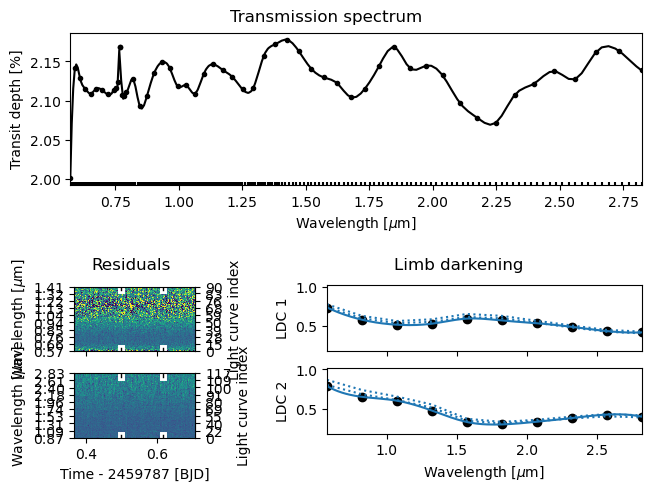

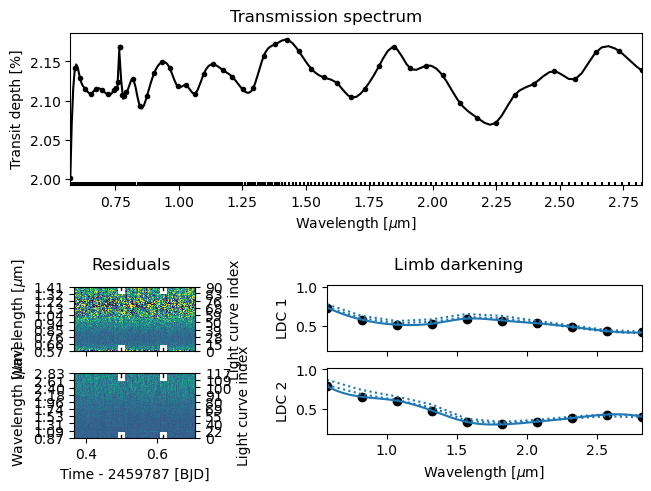

In [57]:
ts.plot_fit()

In [22]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

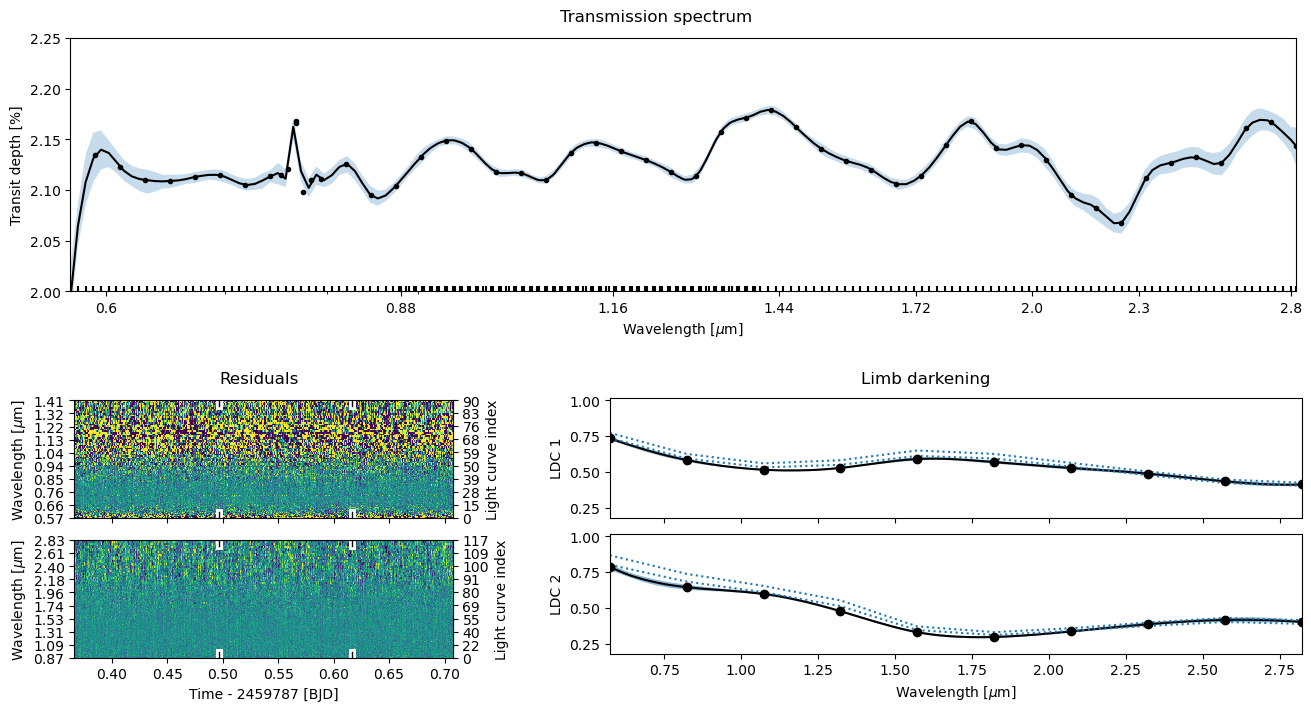

In [21]:
fig = ts.plot_fit(result='mcmc', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

---

<center>&copy;2024 Hannu Parviainen</center>